# Task 2: Sentiment and Thematic Analysis

This notebook quantifies review sentiment and identifies themes to uncover satisfaction drivers and pain points for three Ethiopian banks, as per project requirements.

In [1]:
import pandas as pd
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:
# Load the cleaned reviews from Task 1
input_path = '../data/bank_reviews_cleaned.csv'
assert os.path.exists(input_path), f'Input file not found: {input_path}'
df = pd.read_csv(input_path)
df = df.reset_index(drop=True)
df['review_id'] = df.index + 1  # Add review_id as required
df.head()

,review,rating,date,bank,source,review_id
0,really am happy to this app it is Siple to use...,5,2025-06-07,Commercial Bank of Ethiopia,Google Play,1
1,I liked this app. But the User interface is ve...,2,2025-06-07,Commercial Bank of Ethiopia,Google Play,2
2,"""Why don’t your ATMs support account-to-accoun...",4,2025-06-06,Commercial Bank of Ethiopia,Google Play,3
3,what is this app problem???,1,2025-06-05,Commercial Bank of Ethiopia,Google Play,4
4,the app is proactive and a good connections.,5,2025-06-05,Commercial Bank of Ethiopia,Google Play,5


In [7]:
# Sentiment analysis using distilbert-base-uncased-finetuned-sst-2-english
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
reviews = df['review'].astype(str).tolist()
sentiments = []
batch_size = 64
for i in range(0, len(reviews), batch_size):
    batch = reviews[i:i+batch_size]
    sentiments.extend(sentiment_pipeline(batch, truncation=True))

def signed_score(sentiment):
    if sentiment['label'] == 'POSITIVE':
        return sentiment['score']
    elif sentiment['label'] == 'NEGATIVE':
        return -sentiment['score']
    else:
        return 0

df['sentiment_label'] = [s['label'] for s in sentiments]
df['sentiment_score'] = [signed_score(s) for s in sentiments]
df.head()

Device set to use cpu


,review,rating,date,bank,source,review_id,sentiment_label,sentiment_score
0,really am happy to this app it is Siple to use...,5,2025-06-07,Commercial Bank of Ethiopia,Google Play,1,POSITIVE,0.998870
1,I liked this app. But the User interface is ve...,2,2025-06-07,Commercial Bank of Ethiopia,Google Play,2,NEGATIVE,-0.999684
2,"""Why don’t your ATMs support account-to-accoun...",4,2025-06-06,Commercial Bank of Ethiopia,Google Play,3,NEGATIVE,-0.996465
3,what is this app problem???,1,2025-06-05,Commercial Bank of Ethiopia,Google Play,4,NEGATIVE,-0.999623
4,the app is proactive and a good connections.,5,2025-06-05,Commercial Bank of Ethiopia,Google Play,5,POSITIVE,0.999868


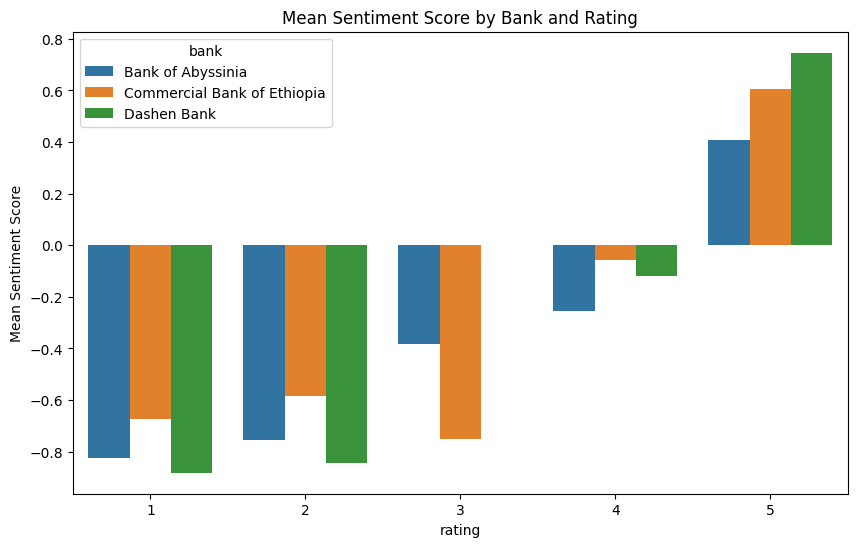

In [9]:
# Aggregate mean sentiment score by bank and rating
agg = df.groupby(['bank', 'rating'])['sentiment_score'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=agg, x='rating', y='sentiment_score', hue='bank')
plt.title('Mean Sentiment Score by Bank and Rating')
plt.ylabel('Mean Sentiment Score')
plt.show()

In [10]:
# Extract top keywords per bank using TF-IDF
tfidf = TfidfVectorizer(max_features=100, stop_words='english', ngram_range=(1,2))
for bank in df['bank'].unique():
    bank_reviews = df[df['bank'] == bank]['review'].astype(str)
    X = tfidf.fit_transform(bank_reviews)
    indices = X.sum(axis=0).A1.argsort()[::-1]
    features = tfidf.get_feature_names_out()
    top_keywords = [features[i] for i in indices[:10]]
    print(f"Top keywords for {bank}: {top_keywords}")

Top keywords for Commercial Bank of Ethiopia: ['app', 'good', 'best', 'nice', 'cbe', 'like', 'bank', 'great', 'good app', 'easy']
Top keywords for Bank of Abyssinia: ['app', 'good', 'bank', 'boa', 'work', 'working', 'best', 'use', 'application', 'mobile']
Top keywords for Dashen Bank: ['app', 'best', 'dashen', 'bank', 'good', 'super', 'banking', 'use', 'amazing', 'easy']


## Thematic Grouping Logic

To identify recurring themes in user reviews, we manually grouped significant keywords and phrases (extracted via TF-IDF and domain knowledge) into 3–5 overarching categories per the project instructions:

- **Account Access Issues:**  
  Includes keywords/phrases related to login problems, password issues, account lockouts, and access difficulties (e.g., "login", "cannot login", "account locked", "reset password").

- **Transaction Performance:**  
  Captures issues with money transfers, transaction delays, failed or pending transactions, and related complaints (e.g., "transfer", "delay", "pending", "not received", "deducted").

- **User Interface & Experience:**  
  Encompasses feedback on the app’s usability, design, navigation, responsiveness, and general user experience (e.g., "app", "update", "interface", "easy", "crash", "bug", "good", "best").

- **Customer Support:**  
  Covers mentions of support quality, help requests, response times, and customer service interactions (e.g., "support", "help", "service", "response", "customer care").

- **Feature Requests:**  
  Includes suggestions for new features, requests for additional options, or mentions of missing functionality (e.g., "feature", "add", "option", "request", "please add", "suggestion").

**Assignment Method:**  
For each review, if any of the theme’s keywords/phrases appear in the text, the corresponding theme is assigned. Reviews may be assigned multiple themes if multiple keyword sets are present. If no keywords match, the review is labeled as "Other".

In [13]:
# Define themes and their associated keywords/phrases
themes = {
    'Account Access Issues': [
        'login', 'password', 'access', 'account locked', 'cannot login', 'sign in', 'log in', 'reset', 'forgot'
    ],
    'Transaction Performance': [
        'transfer', 'delay', 'transaction', 'processing', 'pending', 'failed', 'slow transfer', 'not received', 'deducted'
    ],
    'User Interface & Experience': [
        'app', 'update', 'interface', 'easy', 'design', 'navigation', 'crash', 'bug', 'responsive', 'layout', 'good', 'best', 'nice', 'great', 'super', 'amazing'
    ],
    'Customer Support': [
        'support', 'help', 'service', 'response', 'call', 'contact', 'assistance', 'customer care'
    ],
    'Feature Requests': [
        'feature', 'add', 'option', 'request', 'would like', 'please add', 'missing', 'suggestion'
    ]
}

def assign_theme(row):
    text = str(row['review']).lower()
    assigned = []
    for theme, keywords in themes.items():
        if any(kw in text for kw in keywords):
            assigned.append(theme)
    return ', '.join(assigned) if assigned else 'Other'

df['identified_theme(s)'] = df.apply(assign_theme, axis=1)
df.head()

,review,rating,date,bank,source,review_id,sentiment_label,sentiment_score,identified_theme(s)
0,really am happy to this app it is Siple to use...,5,2025-06-07,Commercial Bank of Ethiopia,Google Play,1,POSITIVE,0.998870,User Interface & Experience
1,I liked this app. But the User interface is ve...,2,2025-06-07,Commercial Bank of Ethiopia,Google Play,2,NEGATIVE,-0.999684,User Interface & Experience
2,"""Why don’t your ATMs support account-to-accoun...",4,2025-06-06,Commercial Bank of Ethiopia,Google Play,3,NEGATIVE,-0.996465,"Transaction Performance, Customer Support"
3,what is this app problem???,1,2025-06-05,Commercial Bank of Ethiopia,Google Play,4,NEGATIVE,-0.999623,User Interface & Experience
4,the app is proactive and a good connections.,5,2025-06-05,Commercial Bank of Ethiopia,Google Play,5,POSITIVE,0.999868,User Interface & Experience


In [14]:
output_path = '../data/bank_reviews_with_sentiment_and_themes.csv'
export_df = pd.DataFrame({
    'review_id': df['review_id'],
    'review_text': df['review'],
    'sentiment_label': df['sentiment_label'],
    'sentiment_score': df['sentiment_score'],
    'identified_theme(s)': df['identified_theme(s)']
})
export_df.to_csv(output_path, index=False)
print(f'Saved final results to {output_path}')

Saved final results to ../data/bank_reviews_with_sentiment_and_themes.csv
